"""
 In this version, the coding has been separated into sections to facilitate ease of reading.
 
 this version uses the sonic location as the reference point, so there is a
 different reference point for each sensor+sonic locations set.
 results are very good. see last plots. 

 this version also adds multiple sets of sensors and sonics
 so for each case (file) there are number_sensors * number_sensor_sets records.
 A set of sensor locations and a sonic location are assigned, data for those
 locations are pulled from the files and added to the NN input tensor, then 
 the next set of sensor locations and sonic location are assigned, data are
 pulled from the files for those locations and added to the NN input, etc
 The data for all the sensor+sonic arrangements are used in one training.
 The coding is general, except for parts of the initialization, I am just using 
 3 sensor locations and a sonic, and taking 3 sets of these. Any other number
 of sensors and sonics could be used, but the computational burden will increase.
 Here, I'm just testing the computer program with a few reasonable field arrangements.
 It works almost as well as for a single set of sensor locations and sonic.  

 still need to integrate with NCAR's initialization. I see that instructions
 for doing that are on their github site.

 train CNN ~ to arpa-e publication (Travis, Dubey & Sauer 2020, Neural Networks 
    to locate and quantify fugitive  natural gas leaks for a MIR detection system,
     Atmospheric Environment X. vol. 8   https://doi.org/10.1016/j.aeaoa.2020.1000) 
    This version gives better results than the original arpa-e code.
    Reasons: much more training data now - 1 to 2 orders of magnitude more; plus,
             more sophisticated NN model.
             
 a
 assign/determine number of cases, number of sensors per case, 
 list of locations to use for sensors for each case (random?, specified?)
 loop over training data files:
 from list, determine sensor cells and coords and scale, for each case j
 collect from training data files source info - coords, rate, for each case
 find Qsmin, Qsmax = min, max source leak rates over all cases
 scale leak rates Qs as Qscl=log(max(Qs,eps)/Qsmin)/log(Qsmax/Qsmin), eps very small.
 read velocities & transform velocities (u,v,w) to (ur,utheta,w) to (speed,angle,w)
 pull out CH4 values for case.j; pull out CH4(time) for sensors.i,j
 mark time of first detect of CH4 > CH4min for each case j 
 for each sensor i,j find Cmax.i,j and time_max i,j for each case j
 Cmax = max(Cmax.i,j) = overall max concentration
 scaling. Csclmax=log(max(C,eps)/Cmin)/log(Cmax/Cmin)
 compute average velocity by integrating (u,v,w) back from time_max.i,j for delta.time
 delta.time ~ time for avg vel to cross domain to sensor.i,j 
 inputs: (x,y,z.sensor,Cmax,time_max).i,j
 outputs: (xsource,ysource,Qs).j
 run through NN (and try other algs); unscale
 test against subset of inputs,outputs pairs (not used for training).               

 look at time series of CH4 and wind direct,ion
 winds vary greatly; how well will velocity at sonic
 correlate with ch4 at sensor points, and winds along
 path from source to sensor?
 can look at simple correlation; in arpa-e, we looked at
 average velocity over preceding delta.time interval, given
 by size of domain divided by average speed. Instead of 
 full time series, we used time of max CH4 at sensor, assuming
 that reflected an especially direct path between source and sensor.

 Fourier (cosine) transform 'angle'
 is wind history at one point ~ as history at any other point? ergodicity?
"""

In [1]:
# IMPORTS

#conda list -n myenv

#module load conda
#conda env create -f environment.yml
#conda activate seals

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr

from glob import glob

import os

import math
from numpy import random

!pip install keras
!pip install tensorflow
import tensorflow as tf
import keras.layers as layers
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

print('\n numpy version ',np.__version__)


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2024-01-14 16:22:53.755084: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:22:53.759388: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:22:53.795181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:22:53.795209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:22:53.796510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to


 numpy version  1.24.4


In [2]:
# INPUT PARAMETERS

# assign values to a number of parameters used in the model

# read every nth file
# skip1 for skipping over subdirectories (read files in every skip1-th subdirectory; 1=read every directory)
# skip2 for skipping over files in each subdirectory (read every skip2-th file; 1=read every file in subdirectory)

skip1=1
skip2=1

# pick a file for some plots (pick = n-th file of files being read in)

pick=5

# index in timeDim for 2-D plots for 'pick' file to use

k_pick_plot2d=20

# define number of sensors and k,j,i locations.

# here just using 3 sets of sensors (CH4 and sonic) to get started; 
# NN section is for arbitrary number of sensors.

# picking semi-random sensor locations for testing

number_sensor_sets=3
number_sensors=3
sensor_x_i=np.array([29,29,29,28,24,16,29,25,21])
sensor_y_i=np.array([15,22,29,16,26,28,14,18,22])
sensor_z_i=np.array([1,1,1,1,1,1,1,1,1])

sensor_x_scl=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])
sensor_y_scl=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])
sensor_z_scl=np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.])

# k,j,i for met sensor

# picking points towards the left side.
# just to have something to work with for testing.
# x,y,z indices for each sensor location.

sonic_x_i=([1,4,8])
sonic_y_i=([13,10,3])
sonic_z_i=([2,2,2])

# factor indicates how much of domain width to use
# to stop backtracking. factor should be >= 0 but < ~0.5
# e.g., if factor = 0.25, then backtracking will track
# back a distance from sensor location = to 0.25*xscale.  

factor_x=0.5
factor_y=0.5

# fraction of data to hold out for testing/prediction after training
# (not fraction to be used for validation by model.fit; letting
# validation_split=val_frac=0.2 or whatever to partition training data into training
# and validation)

val_frac=0.2

number_epochs=50

prcnt=0.1

# threshhold value for CH4 concentrations.
#  ambient value ~ 1.8 ppm (by volume) ~ 1 ppm by mass
# scaling of CH4 log(max(CH4,CH4_bckgrd)/CH4_bckgrd)/log(CH4max/CH4_bckgrd)

CH4_bckgrd=1.e-6

# scaling for velocity components

speed_max=1.

n_ins=0

# initialize global CH4 and Q_leak max

CH4_max_global=0.
Q_leak_max_global=0.
Q_leak_min=0.3*1.0e-2

# initialize random number generator

random.seed(42)


In [3]:
# INPUT FILES

# path to Jeremy and Domingo's files

files_path='/glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23'
sub_dirs=os.listdir(files_path)
nsubs=len(sub_dirs)
print('nsubs =',nsubs,'\n sub_dirs=',sub_dirs)

# create list of files in the subdirectories

files_l_i=[' ']*nsubs
dir_label=[' ']*nsubs
num_files=[0]*nsubs
total_files=0
files_l=list([' ']*10000)

# determine total number of files to read = number of cases

cc=-1
for i in range(0,nsubs,skip1):
    dir_label[i]=files_path+'/'+sub_dirs[i]+'/'
    files_l_i[i]=os.listdir(dir_label[i])
    num_files[i]=len(files_l_i[i])
    for j in range(0,num_files[i],skip2):
        cc+=1
        files_l[cc]=dir_label[i]+files_l_i[i][j]
        
total_files=cc+1

# shuffle list of indices for file names
        
ij_shuffled=np.arange(0,total_files,1)

print('ij_shuffled:before=',ij_shuffled)

random.shuffle(ij_shuffled)

print('ij_shuffled:after=',ij_shuffled)


nsubs = 1 
 sub_dirs= ['WD']
ij_shuffled:before= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
ij_shuffled:after= [ 55  40  19  31  98  56  69 104  81  26  94  27  64   4  96 113  36  80
 125  84  18  10 118  11 105  45  70  78  47   0  12  42 126  24  67 111
  89  15  77  22  44  65  95  30  62 121   9  33  66  25 115  28  97  91
  53   5  68  73  39  49  35  16 122  34  85   7  43  76 112 108   8  13
  93   3  17  38  72 100   6  83 110 119  54  50 117  46 123  61 124  79
 101  41  58  90  48  88 109  57  75  32 120  

In [4]:
# DEFINE INPUT AND OUTPUT VECTORS FOR NN

# define size of input and output vectors for NN

total_files_xns=total_files*number_sensors*number_sensor_sets

v_input=np.zeros(shape=[4*number_sensors+2,total_files_xns])
v_output=np.zeros(shape=[4,total_files_xns])

# array for CH4 vs time at sensor locations
# here for testing, assuming 3 ch4 sensors per sensor set

b_ts_ch4_sensor_i=[[],[],[]]

print('v_input shape =',v_input.shape)
print('v_output shape =',v_output.shape)


v_input shape = (14, 1152)
v_output shape = (4, 1152)


In [5]:
# FUNCTION polar

# convert u,v time series at a point to wind speed, wind direction

# inputs:
# u = horizontal wind in x direction (E-W)
# v = horizontal wind in y direction (N-S)
# n = length of u,v vectors

# outputs:
# angle = angle (degrees) of horizontal wind vector (0 = East; ccw)
# speed = magnitude of horizontal wind vector

def polar(angle,speed,u,v,n):
    for i in range(0, n):
        speed[i]=np.sqrt(u[i]**2 + v[i]**2)
        angle[i]=math.degrees(math.atan2(v[i],u[i]))
    return angle,speed

In [6]:
# FUNCTION polar2d

# compute wind speed and direction for 2d u,v wind field 

# inputs:
# u2d = horizontal wind on a horizontal plane (pre-selected)
# v = horizontal wind on horizontal plane (pre-selected) 
# m,n = max indices in x and y directions

# outputs:
# angle2d = angle (degrees) of horizontal winds (0 = East; ccw) at each x-y grid point on plane
# speed2d = magnitude of horizontal winds at each x-y grid point on plane

def polar2d(angle2d,speed2d,u2d,v2d,m,n):
    for i in range(0, m):
        for j in range(0, n):
            speed2d[i][j]=np.sqrt(u2d[i][j]**2 + v2d[i][j]**2)
            angle2d[i][j]=math.degrees(math.atan2(v2d[i][j],u2d[i][j]))
    return angle2d,speed2d

In [7]:
# FUNCTION findmaxC

# find max CH4 concentration in time series for a sensor

# input:
# CH4 vector
# times vector
# n=length of vectors

# output:
# maxC = maximum value of CH4 in time series
# time_maxC = time at which maxC occurs
# ijkmax = index in time series for maxC

def findmaxC(CH4,times,n):
    
    maxC=0.
    time_maxC=0.
    ijkmax=0
    
    for i in range(0,n):
        if CH4[i] > maxC:
            maxC=CH4[i]
            time_maxC=times[i]
            ijkmax=i

    # if no maximum, e.g., constant value for all times, 
    # or CH4 == 0 for all times, then 
    # return mid-point value - this is an arbitrary choice
    
    if maxC == 0. or ijkmax == 0:
        ijkmax=int(n/2)
        time_maxC=times[ijkmax]
        
    return maxC,time_maxC,ijkmax

In [8]:
# FUNCTION backtrack

# backtrack along velocity(t) path until x_length*factor has been traversed
# then return average velocity vector

# inputs:
# ijk_start = index in time series at which to start 
# u_sonic = x component of winds at sonic vs time
# v_sonic = y component of winds at sonic vs time
# dt = time step size
# sensor_x = x-coordinate of sensor
# sensor_y = y-coordinate of sensor
# x_pathmax = max backtrack path length along x axis as fraction of x_width
# y_pathmax = max backtrack path length along y axis as fraction of y_width

# outputs:
# avg_u = average x-coordinate wind vector component over backtrack time interval
# avg_v = average y-coordinate wind vector component over backtrack time interval

def backtrack(ijk_start,u_sonic,v_sonic,dt,sensor_x,sensor_y,x_pathmax,y_pathmax):

    # start at sensor location and current time
    
    xn=sensor_x
    yn=sensor_y
    ijk=ijk_start
    ux_sum=0.
    vy_sum=0.
    xdist=0.
    ydist=0.
    
    while (xdist < x_pathmax or ydist < y_pathmax) and ijk > 0:
        
        u_bar=0.5*(u_sonic[ijk]+u_sonic[ijk-1])
        v_bar=0.5*(v_sonic[ijk]+v_sonic[ijk-1])
        xnm1=xn-dt*u_bar
        ynm1=yn-dt*v_bar
        ijk-=1
        ux_sum+=u_bar
        vy_sum+=v_bar
        xn=xnm1
        yn=ynm1
        xdist=abs(sensor_x-xn)
        ydist=abs(sensor_y-yn)
        
    # compute average horizontal wind components 
    # over backtrack path
    
    avg_u=ux_sum/max(1,(ijk_start-ijk))
    avg_v=vy_sum/max(1,(ijk_start-ijk))
        
    return avg_u,avg_v

In [9]:
# FUNCTION plots_at_pick

# make time plots at sensor points and 2-D plots on specified horizontal plane at specified time for chosen file

# inputs:
# b = array of variables from file
# nx, ny = number of grid points in x and y directions
# ntimes = number of time points in series
# number_sensors = number of CH4 sensors in each sensor set
# dt = time step size (assumed uniform)
# m2 = subscript in 
# k_pick_plot2d = specified kDim level for 2-D plots
# b_ts_u_sonic = wind component along x axis at sonic location, vs time
# b_ts_v_sonic = wind component along y axis at sonic location, vs time
# b_ts_w_sonic = wind component along z axis at sonic location, vs time
# b_ts_ch4_sensor_i = CH4 concentrations vs time at sensor locations
# angle = horizontal velocity angle (degrees) vs time at sonic locations
# speed = horizontal velocity magnitude vs time at sonic locations

# outputs:
# none
    
def plots_at_pick(b,sonic_z_i,nx,ny,ntimes,number_sensors,number_sensor_sets,dt,m2,k_pick_plot2d,
                x_cellwidth,y_cellwidth,b_ts_u_sonic,b_ts_v_sonic,b_ts_w_sonic,b_ts_ch4_sensor_i,angle,speed):
            
    # make some plots to see what CH4 and winds v time looks like at sensor locations
            
    for mm in range(0,number_sensors):
                
        x=np.linspace(0,ntimes*dt,ntimes)
        plt.xlabel('time (secs)')
        plt.ylabel('CH4 (kg/kg)')
        plt.title('at point i,j,k=sensors ')
        plt.plot(x,b_ts_ch4_sensor_i[mm])
        plt.show()
                
    plt.xlabel('time (secs)')
    plt.ylabel('u,v (m/s)')
    plt.title('at point i,j,k=sonic; blue=u,red=v')
    plt.plot(x,b_ts_u_sonic,'b',x,b_ts_v_sonic,'r')
    plt.show()

    plt.xlabel('time (secs)')
    plt.ylabel('vertical wind speed (m/s)')
    plt.title('at point i,j,k=sonic')
    plt.plot(x,b_ts_w_sonic)
    plt.show()
            
    # plot wind angle vs time
        
    plt.xlabel('time (secs)')
    plt.ylabel('wind angle (deg)')
    plt.title('angle: east=0, north=90, south=-90; i,j,k=sonic')
    plt.plot(x,angle)
    plt.show()
        
    # plot wind speed vs time
        
    plt.xlabel('time (secs)')
    plt.ylabel('wind speed (m/s)')
    plt.title('at point i,j,k=sonic')
    plt.plot(x,speed)
    plt.show()
            
    # contour plots of winds on a plane at specified time

    # pull out a u field for plotting
        
    b_2d_xy_u_t20sonic=b.u.isel(timeDim=k_pick_plot2d, kDim=sonic_z_i[m2]).values

    # pull out a v field at same early time
        
    b_2d_xy_v_t20sonic=b.v.isel(timeDim=k_pick_plot2d, kDim=sonic_z_i[m2]).values

    # convert to angle,speed fields
        
    speed2d=np.zeros((nx,ny))
    angle2d=np.zeros((nx,ny))
    out2d=polar2d(angle2d,speed2d,b_2d_xy_u_t20sonic,b_2d_xy_v_t20sonic,nx,ny)
    
    # pull out an x-y CH4 field at same early time on bottom layer to see plume
        
    b_2d_xy_qch4_t20sonic=b.q_CH4.isel(time=k_pick_plot2d, kDim=sonic_z_i[m2]).values
    
    pick_time=k_pick_plot2d*dt
    
    x_loc=nx*x_cellwidth
    y_loc=ny*y_cellwidth
    x_time=x_loc-x_cellwidth
    x_time2=x_time+4*x_cellwidth
    y_time=y_loc
    
    if m2 == number_sensor_sets-1:
        
        # plot u component of winds on specified horizontal plane
        
        fig1,ax2=plt.subplots(layout='constrained')
        xx=np.arange(0.,x_loc,x_cellwidth)        
        yy=np.arange(0.,y_loc,y_cellwidth)
        ax2.set_xlabel('x index')
        ax2.set_ylabel('y index')
        ax2.set_title('horizontal wind, x direction, m/s; k=sonic')
        plt.text(x_time,y_time,'time = ')
        plt.text(x_time2,y_time,pick_time)
        cs=plt.contourf(xx,yy,b_2d_xy_u_t20sonic,cmap=plt.cm.jet)
        cbar=fig1.colorbar(cs)
        plt.show()
                
        # plot v component of winds on specified horizontal plane
                
        fig1,ax2=plt.subplots(layout='constrained')
        xx=np.arange(0.,x_loc,x_cellwidth)        
        yy=np.arange(0.,y_loc,y_cellwidth)
        ax2.set_xlabel('x index')
        ax2.set_ylabel('y index')
        ax2.set_title('horizontal wind, y direction, m/s; k=2')
        plt.text(x_time,y_time,'time = ')
        plt.text(x_time2,y_time,pick_time)
        cs=plt.contourf(xx,yy,b_2d_xy_v_t20sonic,cmap=plt.cm.jet)
        cbar=fig1.colorbar(cs)
        plt.show()
            
        # plot angle field

        fig1,ax2=plt.subplots(layout='constrained')
        xx=np.arange(0.,x_loc,x_cellwidth)        
        yy=np.arange(0.,y_loc,y_cellwidth)
        ax2.set_xlabel('x index')
        ax2.set_ylabel('y index')
        ax2.set_title('wind direction, degrees; k=sonic; 0=e, 90=n')
        plt.text(x_time,y_time,'time = ')
        plt.text(x_time2,y_time,pick_time)
        cs=plt.contourf(xx,yy,angle2d,cmap=plt.cm.jet)
        cbar=fig1.colorbar(cs)
        plt.show()
                                   
        # plot speed field
        
        fig1,ax2=plt.subplots(layout='constrained')
        xx=np.arange(0.,x_loc,x_cellwidth)        
        yy=np.arange(0.,y_loc,y_cellwidth)
        ax2.set_xlabel('x index')
        ax2.set_ylabel('y index')
        ax2.set_title('wind speed  m/s; k=sonic')
        plt.text(x_time,y_time,'time = ')
        plt.text(x_time2,y_time,pick_time)
        cs=plt.contourf(xx,yy,speed2d,cmap=plt.cm.jet)
        cbar=fig1.colorbar(cs)
        plt.show()
            
        # plot CH4 field at early time
            
        fig1,ax2=plt.subplots(layout='constrained')
        xx=np.arange(0.,x_loc,x_cellwidth)        
        yy=np.arange(0.,y_loc,y_cellwidth)
        ax2.set_xlabel('x index')
        ax2.set_ylabel('y index')
        ax2.set_title('CH4 concentration, kg/kg; k=sonic')
        plt.text(x_time,y_time,'time = ')
        plt.text(x_time2,y_time,pick_time)
        cs=plt.contourf(xx,yy,b_2d_xy_qch4_t20sonic,cmap=plt.cm.jet)
        cbar=fig1.colorbar(cs)
        plt.show()
        
    return
      

In [10]:
# FUNCTION make_plots_recovered

# plots for recovered x,y source locations and leak rate. and scatter plots
# leak rate recovery accuracy reflected in color of circles - color reflects error rel magnitude

# input:
# n_cases = number of scatter points
# n_files = number of files in this plotting group
# number_sensors = number of CH4 sensors in sensor set
#                  currently assume all sensor sets have 
#                  same number of sensors
# number_sensor_sets = number of sensor sets (CH4 + sonic)
# y_predicted = predicted output for cases
# y_data = true values of output for cases
# xyzscale = length scale
# x_cellwidth, y_cellwidth = length and width of each grid cell
# xref, yref = x and y coordinates of reference locations 
# xvals, yvals = x and y coordinates of lower left corner of domain
# sensor_x_i, sensor_y_i = x and y coordinates of sensor locations
# sonic_x_i, sonic_y_i = x and y coordinates of sonic location

# output:
# none

def make_plots_recovered(n_cases,number_sensor_sets,number_sensors,n_files,y_predicted,
                     y_data,xyzscale,x_cellwidth,y_cellwidth,xref,yref,xvals,yvals,
                     sensor_x_i,sensor_y_i,sonic_x_i,sonic_y_i,label_pointer):

    x=np.linspace(0,n_cases-1,n_cases)

    # define working arrays
    
    y_diff2=0.
    y_actual=np.zeros(shape=[n_cases])
    y_model=np.zeros(shape=[n_cases])
    var_range=np.zeros(shape=[4,2])

    top_label=['training: actual in blue, predicted in red ','holdouts: actual in blue, predicted in red ',
              'training: Q partially unscaled: actual in blue, predicted in red ',
              'holdouts: Q partially unscaled: \n actual in blue, predicted in red ',
              'recovered source locations, training cases \n and color-coded leak rate errors',
              'recovered source locations, holdout cases \n and color-coded leak rate errors']
   
    label=['X source location','Y source location','Z source vertical','Q leak rate']

    var_range=[[0.,1.0],[0.,1.0],[0.,0.10],[0.,2.0]]  

    for k in range(0,4):
        if k < 2:
            i=-1
            for m in range(0,n_files):
                for j in range(0,number_sensor_sets):
                    for jj in range(0,number_sensors):
                        i+=1
                        y_diff2+=(y_data[i][k]-y_predicted[i][k])**2
                        if k == 0:
                            y_actual[i]=(y_data[i][k]*xyzscale+xref[j]-xvals[0])/xyzscale
                            y_model[i]=(y_predicted[i][k]*xyzscale+xref[j]-xvals[0])/xyzscale
                        if k == 1:
                            y_actual[i]=(y_data[i][k]*xyzscale+yref[j]-yvals[0])/xyzscale
                            y_model[i]=(y_predicted[i][k]*xyzscale+yref[j]-yvals[0])/xyzscale
        if k > 1:
            for i in range(n_cases):
                y_diff2+=(y_data[i][k]-y_predicted[i][k])**2
                y_actual[i]=y_data[i][k]
                y_model[i]=y_predicted[i][k]     
        
        plt.axis([0,n_cases-1,var_range[k][0],var_range[k][1]])
        plt.xlabel('input record number')
        plt.ylabel(label[k])
        plt.title(top_label[label_pointer])
        plt.plot(x,y_actual,'b',y_model,'r')
        plt.show()

        rmse=np.sqrt(y_diff2/float(4.*n_cases))
    
    # unscale (partially) the leak rate
    
    for i in range(0,n_cases):
        y_actual[i]=10.**(y_data[i][3]*Q_scale)*Q_leak_min/Q_leak_max_global
        y_model[i]=10.**(y_predicted[i][3]*Q_scale)*Q_leak_min/Q_leak_max_global

    plt.axis([0,n_cases-1,0.,2.])
    plt.xlabel('input record number')
    plt.ylabel(label[3])
    plt.title(top_label[label_pointer+2])
    plt.plot(x,y_actual,'b',y_model,'r')
    plt.show()

    print(' rmse =',rmse)

    # scatterplot for recovered x,y source locations 
    # leak rate recovery accuracy reflected in color of
    # circles - color reflects error 
            
    plt.axis([0.,1.,0.,1.])
    plt.xlabel('X, scaled')
    plt.ylabel('Y, scaled')
    plt.title(top_label[label_pointer+4])
    xcxyz=x_cellwidth/xyzscale
    ycxyz=y_cellwidth/xyzscale
    plt.scatter(sensor_x_i*xcxyz,sensor_y_i*ycxyz,marker='x')
 
    for mk in range(0,number_sensor_sets):
        mk3=mk*number_sensors
        sonic_x=(sonic_x_i[mk]-0.5)*xcxyz
        sonic_y=(sonic_y_i[mk]-0.5)*ycxyz
        plt.plot(sonic_x,sonic_y,marker='d')
        path_x=np.zeros(shape=[number_sensors])
        path_y=np.zeros(shape=[number_sensors])
        for mj in range(0,number_sensors):
            path_x[mj]=sensor_x_i[mk3+mj]*xcxyz
            path_y[mj]=sensor_y_i[mk3+mj]*ycxyz
        plt.plot(path_x,path_y)
    plt.text(0.09,0.94,'X = sensor location')
    plt.plot(0.10,0.90,marker='d')
    plt.text(0.11,0.90,' = sonic location')
    
    x_scttr=np.empty(shape=[n_cases])
    y_scttr=np.empty(shape=[n_cases])
    color=np.empty(shape=[n_cases])

    i=-1
    for m in range(0,n_files):
        for j in range(0,number_sensor_sets):
            for jj in range(0,number_sensors):
                i+=1
                x_scttr[i]=(y_predicted[i][0]*xyzscale+xref[j]-xvals[0])/xyzscale
                y_scttr[i]=(y_predicted[i][1]*xyzscale+yref[j]-yvals[0])/xyzscale
                color[i]=abs(y_data[i][3] - y_predicted[i][3])
                
    plt.scatter(x_scttr,y_scttr,c=color,cmap='rainbow')
    plt.colorbar()
    plt.show()
    
    return

record number index, shuffled index = 0 55
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS4_src1-8kg_b.6
nx,ny,nz,xyzscale= 30 30 15 60.0
t_zero,times[nt1],dt,timescale= 16200.001 18000.0 5.0 1799.999
x,y,z,q.source= 30.0 30.0 -0.5000677108764648 10.0
record number index, shuffled index = 1 40
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS2_src10kg_b.6
nx,ny,nz,xyzscale= 30 30 15 60.0
t_zero,times[nt1],dt,timescale= 16200.001 18000.0 5.0 1799.999
x,y,z,q.source= 30.0 30.0 -0.5000677108764648 10.0
record number index, shuffled index = 2 19
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS2_src10kg_b.3
nx,ny,nz,xyzscale= 30 30 15 60.0
t_zero,times[nt1],dt,timescale= 16200.001 18000.0 5.0 1799.999
x,y,z,q.source= 30.0 30.0 -0.5000677108764648 10.0
record number index, shuffled index = 3 31
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS

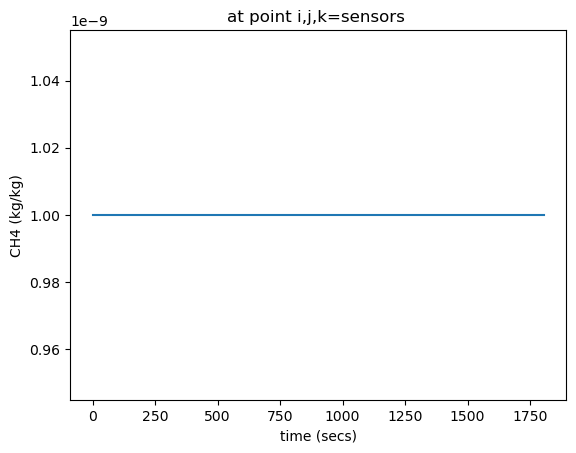

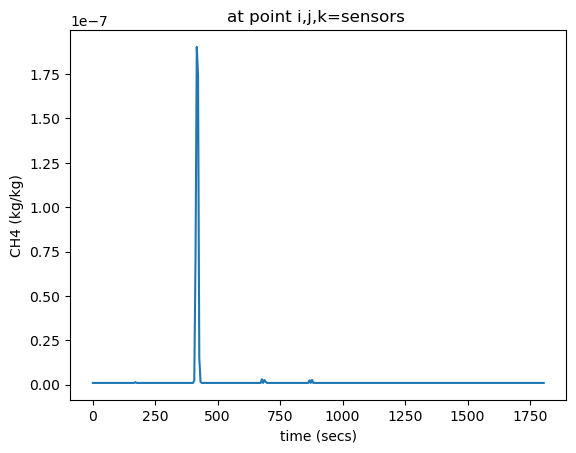

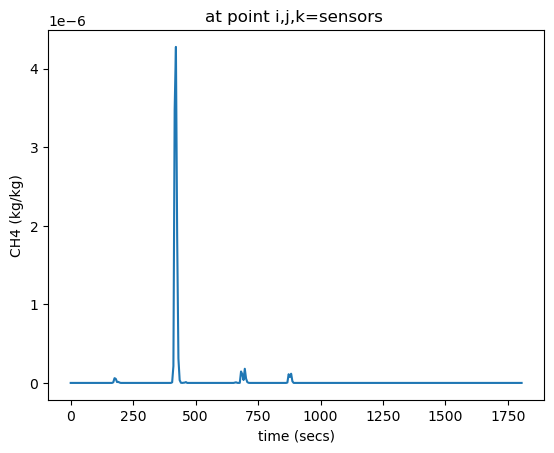

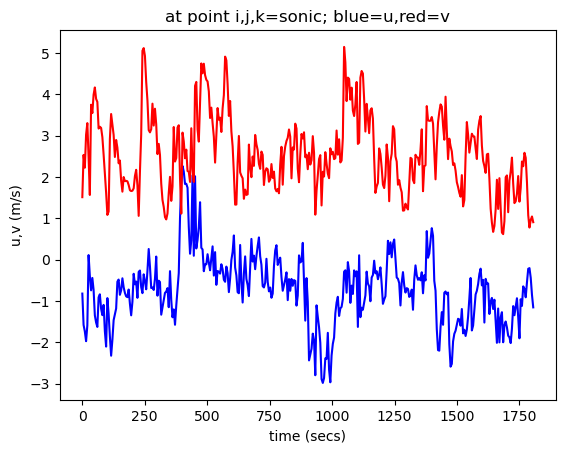

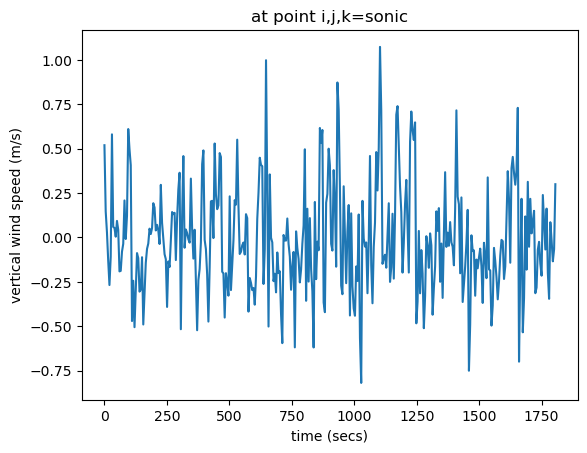

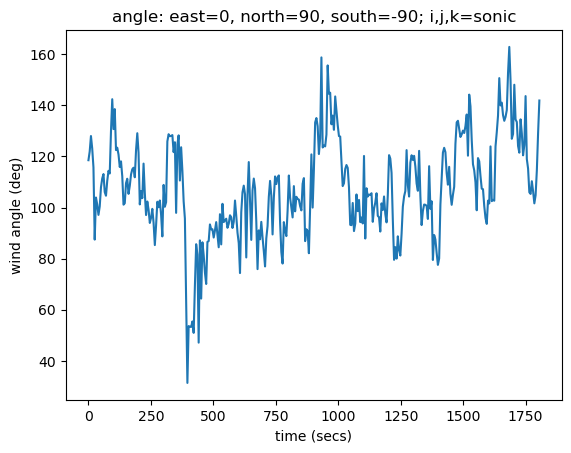

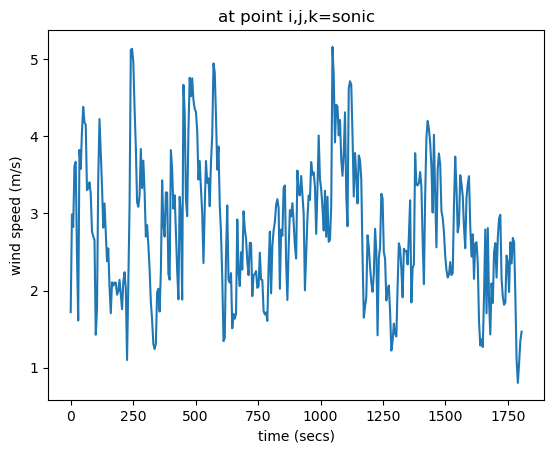

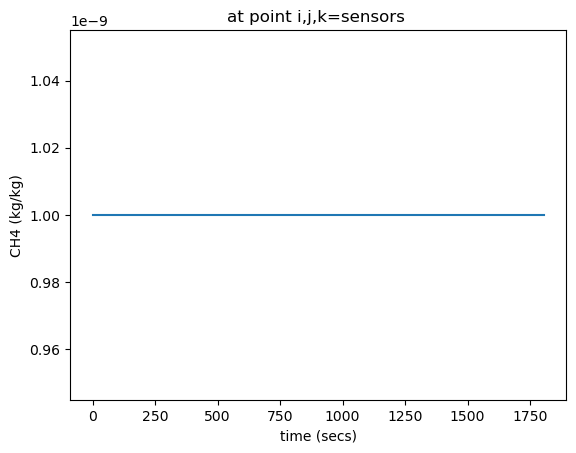

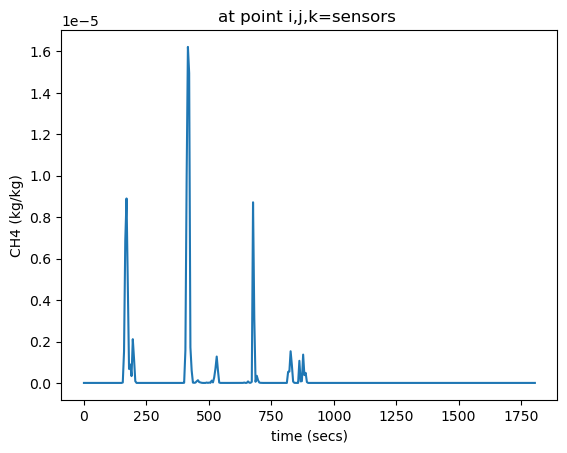

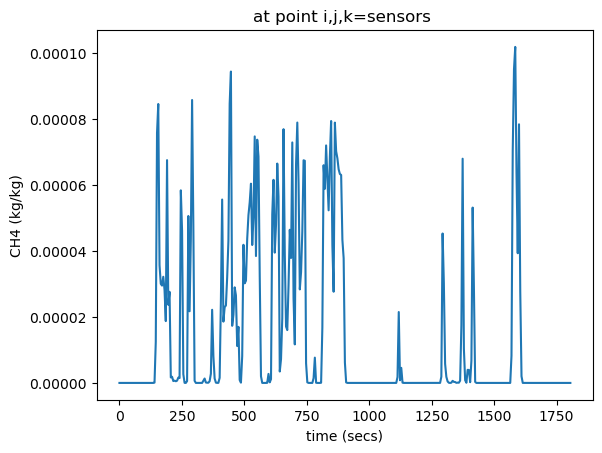

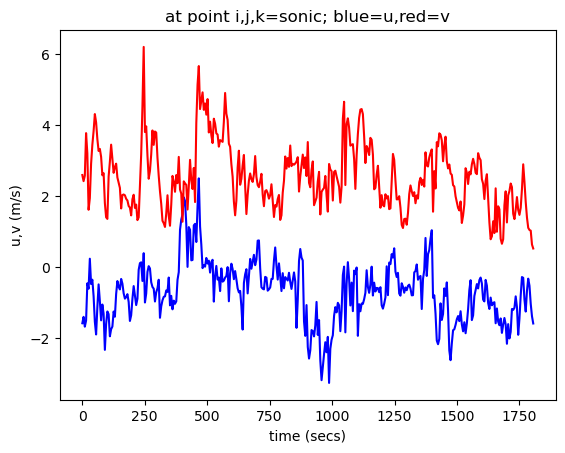

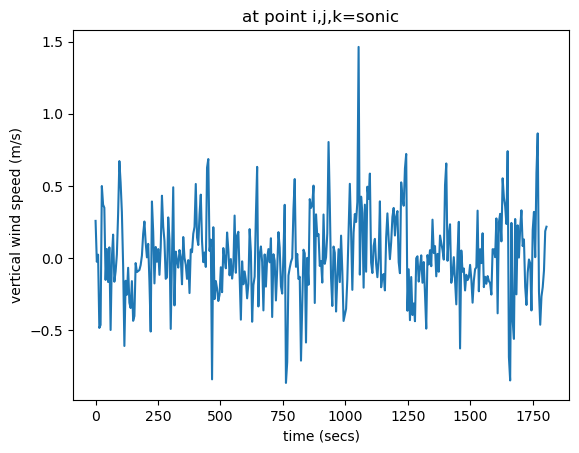

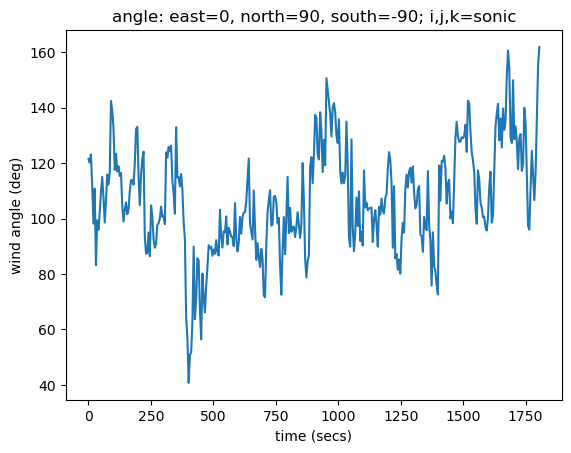

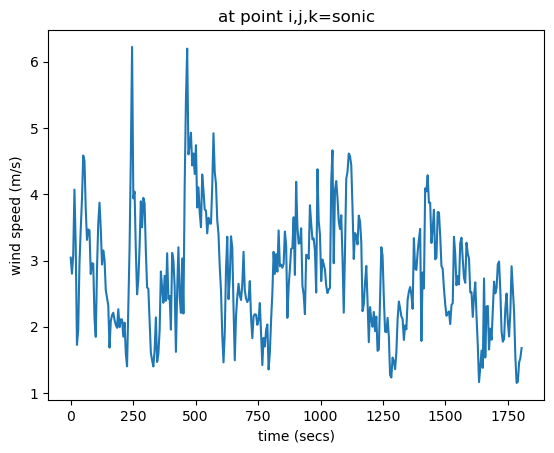

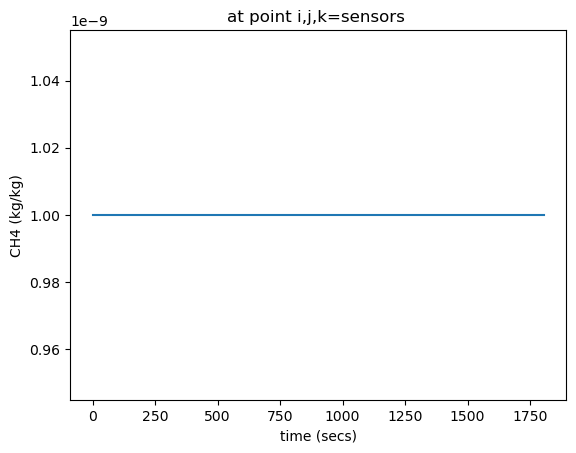

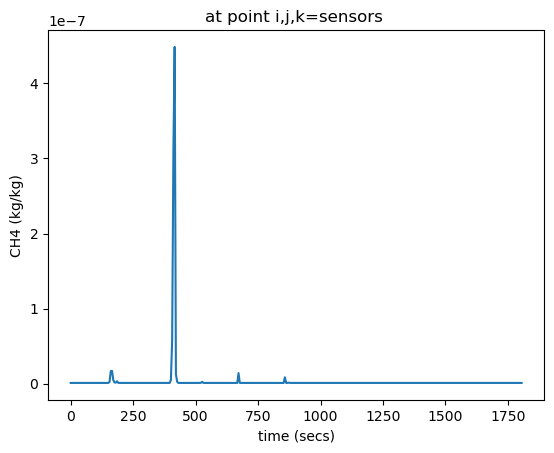

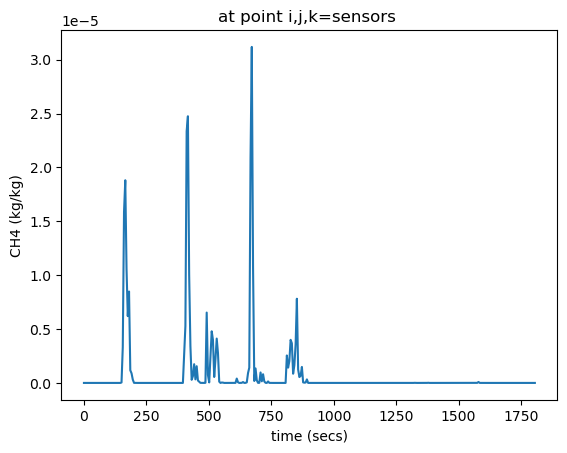

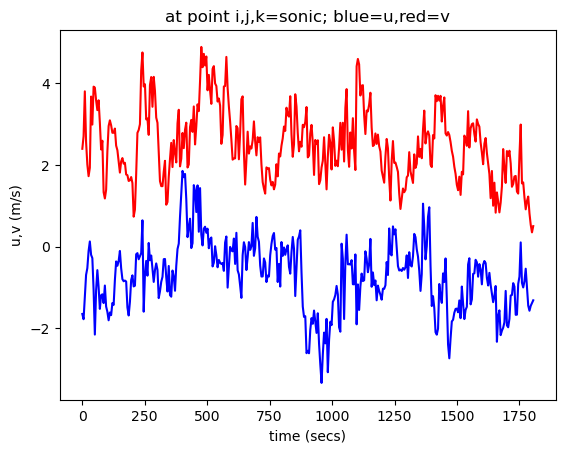

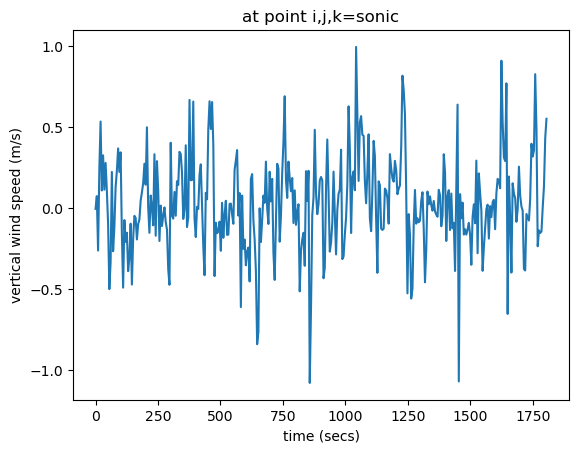

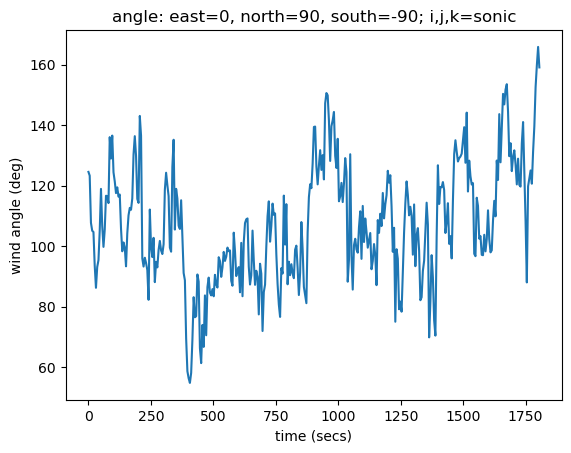

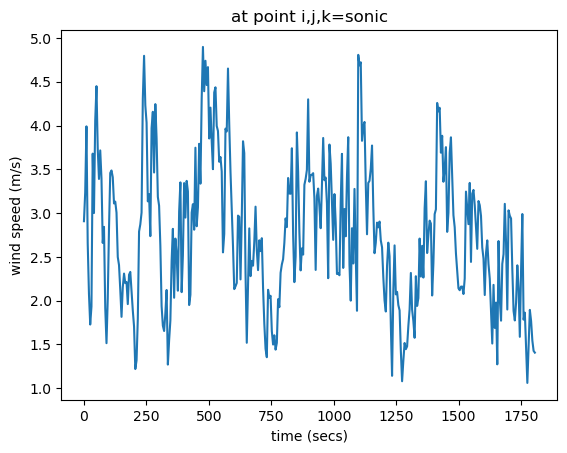

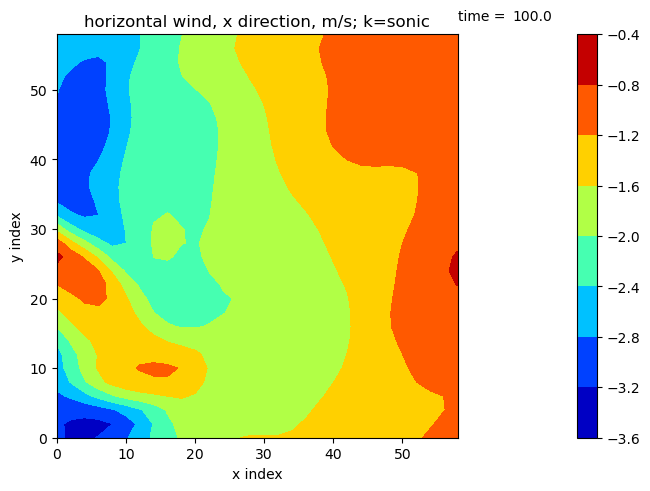

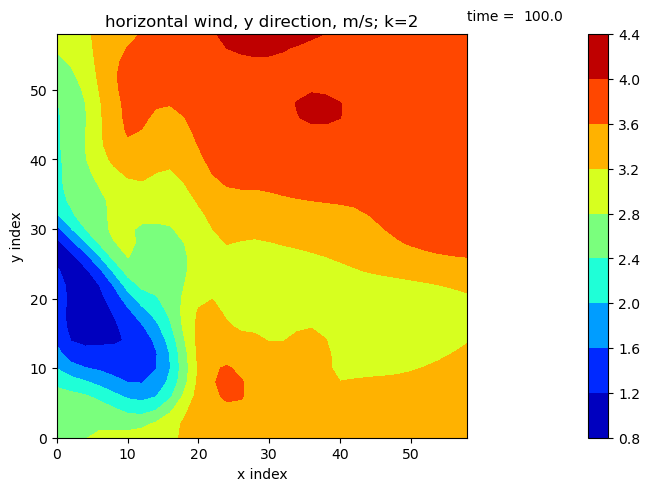

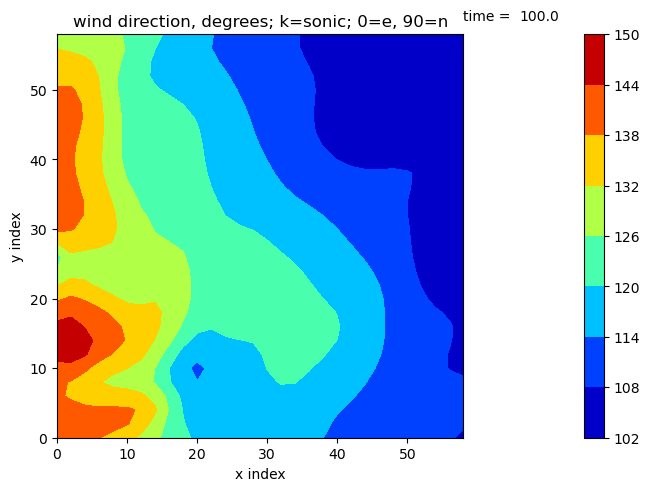

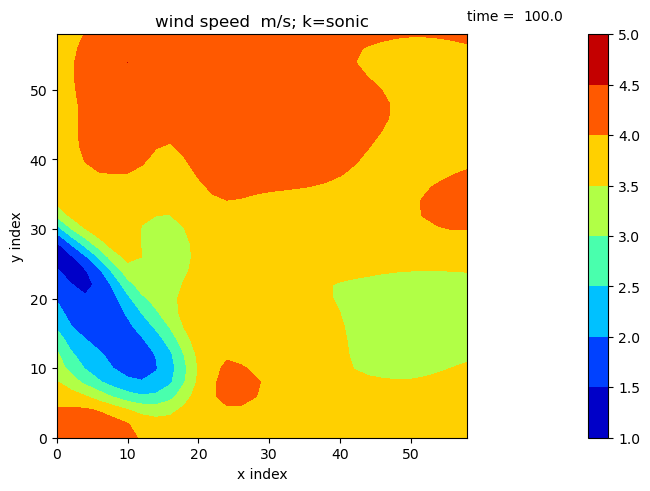

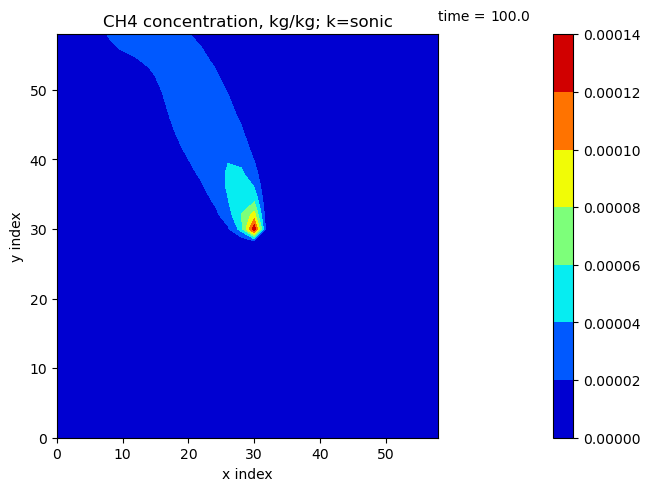

record number index, shuffled index = 6 69
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS6_src10kg_a.1
nx,ny,nz,xyzscale= 30 30 15 60.0
t_zero,times[nt1],dt,timescale= 14400.001 16200.001 5.0 1800.0
x,y,z,q.source= 30.0 30.0 -0.5000677108764648 10.0
record number index, shuffled index = 7 104
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS6_src1-8kg_b.2
nx,ny,nz,xyzscale= 30 30 15 60.0
t_zero,times[nt1],dt,timescale= 16200.001 18000.0 5.0 1799.999
x,y,z,q.source= 30.0 30.0 -0.5000677108764648 10.0
record number index, shuffled index = 8 81
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WDS2_src10kg_a.2
nx,ny,nz,xyzscale= 30 30 15 60.0
t_zero,times[nt1],dt,timescale= 14400.001 16200.001 5.0 1800.0
x,y,z,q.source= 30.0 30.0 -0.5000677108764648 10.0
record number index, shuffled index = 9 26
opened file= /glade/derecho/scratch/jsauer/ForPeople/ForCAMS/SET_12_21_23/WD/CBL2m_WD

In [11]:
# MAIN LOOP

# loop over files to be processed.

# read in one file at a time, pull out data,
# fill in NN input, output vectors.
# after loop, need to scale CH4, Q and (u,v,w).
    
for count in range(0,total_files):
    
    i=ij_shuffled[count]
            
    print('record number index, shuffled index =',count,i)
        
    b=xr.open_dataset(files_l[i])

    print('opened file=',files_l[i])

    # get x coordinate values of domain
        
    xvals=b.xPos.isel(kDim=1,jDim=1).values
    nx=len(xvals)
    nx1=nx-1
    x_cellwidth=xvals[1]-xvals[0]
    
    # get y coordinate values of domain
    
    yvals=b.yPos.isel(kDim=1,iDim=1).values
    ny=len(yvals)
    ny1=ny-1
    y_cellwidth=yvals[1]-yvals[0]

    # get z coordinate values of domain
    
    zvals=b.zPos.isel(jDim=1,iDim=1).values
    nz=len(zvals)
    nz1=nz-1
    z_cellwidth=zvals[1]-zvals[0]

    # use sonic location as reference point for x,y
    
    xref=np.zeros(shape=[number_sensor_sets])
    yref=np.zeros(shape=[number_sensor_sets])
    zref=np.zeros(shape=[number_sensor_sets])
    
    for k2 in range(0,number_sensor_sets):
        xref[k2]=xvals[sonic_x_i[k2]]
        yref[k2]=yvals[sonic_y_i[k2]]
        zref[k2]=max(0.,zvals[0]-z_cellwidth/2.)
        
    # scales in each coord. = size of domain
        
    x_width=xvals[nx1]-xvals[0]+x_cellwidth
    y_width=yvals[ny1]-yvals[0]+y_cellwidth
    z_width=zvals[nz1]-zvals[0]+z_cellwidth

    # length scale = largest of domain size along each axis
    
    xyzscale=max(x_width,y_width,z_width)
    
    # pull out time sequence, set reference time (t_zero), time scale.
    # assuming time points are equally spaced.
            
    times=b.time.values
    ntimes=len(times)
    nt1=ntimes-1
    t_zero=times[0]
    time_scale=times[nt1]-t_zero
    dt=times[1]-times[0]   

    print('nx,ny,nz,xyzscale=',nx,ny,nz,xyzscale)
    print('t_zero,times[nt1],dt,timescale=',t_zero,times[nt1],dt,time_scale)
        
    # scale sensor locations 

    subs=-1
    for k2 in range(0,number_sensor_sets):
        for k in range(0,number_sensors):
            subs+=1
            sensor_x_scl[subs]=(xvals[sensor_x_i[subs]]-xref[k2])/xyzscale
            sensor_y_scl[subs]=(yvals[sensor_y_i[subs]]-yref[k2])/xyzscale
            sensor_z_scl[subs]=(zvals[sensor_z_i[subs]]-zref[k2])/xyzscale
            
    b.srcAuxScLocation
       
    # get x,y,z and q for source

    q_source=b.srcAuxScMassSpecValue.values[0]
    x_source=b.srcAuxScLocation.values[0,0]
    y_source=b.srcAuxScLocation.values[0,1]
    z_source=b.srcAuxScLocation.values[0,2]

    print('x,y,z,q.source=',x_source-xvals[0],y_source-yvals[0],z_source-zvals[0],q_source)
    
    # scale source location coordinates 

    x_source_scl=np.zeros(shape=[number_sensor_sets])
    y_source_scl=np.zeros(shape=[number_sensor_sets])
    z_source_scl=np.zeros(shape=[number_sensor_sets])
    
    for m1 in range(0,number_sensor_sets):
        x_source_scl[m1]=(x_source-xref[m1])/xyzscale
        y_source_scl[m1]=(y_source-yref[m1])/xyzscale
        z_source_scl[m1]=(z_source-zref[m1])/xyzscale
            
    # track maximum leak rate, to use for scaling
        
    Q_leak_max_global=max(Q_leak_max_global,q_source)
        
    # pull out CH4 data (x,y,z,t)
    
    b.q_CH4

    for m2 in range(0,number_sensor_sets):
        
        # pull out time series at sensor points

        m3=m2*3
        for m in range(0,number_sensors):
            subm=m3+m
            b_ts_ch4_sensor_i[m]=b.q_CH4.isel(kDim=sensor_z_i[subm], jDim=sensor_y_i[subm], iDim=sensor_x_i[subm]).values

        # get u,v vs t at sonic location
        
        b_ts_u_sonic=b.u.isel(kDim=sonic_z_i[m2], jDim=sonic_y_i[m2], iDim=sonic_x_i[m2]).values
        b_ts_v_sonic=b.v.isel(kDim=sonic_z_i[m2], jDim=sonic_y_i[m2], iDim=sonic_x_i[m2]).values   
        b_ts_w_sonic=b.w.isel(kDim=sonic_z_i[m2], jDim=sonic_y_i[m2], iDim=sonic_x_i[m2]).values

        # convert u,v to angle,speed
        
        angle=np.zeros(ntimes)
        speed=np.zeros(ntimes)
        out=polar(angle,speed,b_ts_u_sonic,b_ts_v_sonic,ntimes)
        
        # make some plots
        
        if pick == count:
            
            sp=plots_at_pick(b,sonic_z_i,nx,ny,ntimes,number_sensors,number_sensor_sets,dt,m2,k_pick_plot2d,
                             x_cellwidth,y_cellwidth,b_ts_u_sonic,b_ts_v_sonic,b_ts_w_sonic,b_ts_ch4_sensor_i,angle,speed)

        # initialize some vectors, arrays  
               
        CH4max=np.zeros(shape=[number_sensors])
        time_CH4max=np.zeros(shape=[number_sensors])
        ijkmax=np.zeros(shape=[number_sensors],dtype=int)
        avg_speed=np.zeros(shape=[number_sensors])
        avg_angle=np.zeros(shape=[number_sensors])
        CH4_assoc=np.zeros(shape=[number_sensors,number_sensors])
        time_assoc=np.zeros(shape=[number_sensors,number_sensors])

        # specify stopping points for backtracking
        
        x_pathmax=factor_x*x_width
        y_pathmax=factor_y*y_width

        # get max CH4 and corresponding time and ijk index for each sensor location
               
        for ii in range(0,number_sensors):
            
            outC=findmaxC(b_ts_ch4_sensor_i[ii],times,ntimes)
            
            CH4max[ii]=outC[0]
            time_CH4max[ii]=outC[1]
            ijkmax[ii]=outC[2]
            
            # capture global max

            CH4_max_global=max(CH4_max_global,outC[0])
            
            # find average velocity over backtrack interval
            # met sensor could be some distance from CH4 sensors
            # could include a lag time ~ time for winds at met to reach 
            # CH4 sensors
            # unscale sensor locations for backtracking
            
            sensx=(sensor_x_scl[m3+ii]*xyzscale+xref[m2]-xvals[0])
            sensy=(sensor_y_scl[m3+ii]*xyzscale+yref[m2]-yvals[0])
                   
            uvavg=backtrack(ijkmax[ii],b_ts_u_sonic,b_ts_v_sonic,dt,
                sensx,sensy,x_pathmax,y_pathmax)
            
            ux_avg=uvavg[0]
            vy_avg=uvavg[1]
                  
            avg_speed[ii]=np.sqrt(ux_avg**2 + vy_avg**2)
            avg_angle[ii]=math.degrees(math.atan2(vy_avg,ux_avg))
            
            speed_max=max(speed_max,abs(avg_speed[ii]))
            
        # find concentrations at other sensors j != i corresponding to peak time at sensor i
     
        for ii in range(0,number_sensors):
            CH4_assoc[ii][ii]=CH4max[ii]
            time_assoc[ii][ii]=time_CH4max[ii]
            for jj in range(0,number_sensors):
                if jj != ii:
                    CH4_assoc[ii][jj]=b_ts_ch4_sensor_i[jj][ijkmax[ii]]
                    time_assoc[ii][jj]=times[ijkmax[ii]]
                  
        # fill in input vector
        # have number_sensors records for each case (case = a file)
        
        for ii in range(0,number_sensors):
            
            ncns=count*number_sensors*number_sensor_sets+m3+ii
                  
            v_input[0][ncns]=avg_speed[ii]

            # scale wind angle after shifting to 0-360
            # and shifting again so that south pole = 0 degrees
            # angles measured counter clockwise
            
            if avg_angle[ii] < 0.:
                avg_angle[ii]+=360.
            avg_angle[ii]+=90.
            if avg_angle[ii] > 360.:
                avg_angle[ii]-=360.
            
            v_input[1][ncns]=avg_angle[ii]/360.
            
            for pq in range(0,number_sensors):
                v_input[pq*4+2][ncns]=sensor_x_scl[m3+pq]
                v_input[pq*4+3][ncns]=sensor_y_scl[m3+pq]
                v_input[pq*4+4][ncns]=sensor_z_scl[m3+pq]
                v_input[pq*4+5][ncns]=CH4_assoc[ii][pq]
                
        # save source info into learning target array
        
            v_output[0][ncns]=x_source_scl[m2]
            v_output[1][ncns]=y_source_scl[m2]
            v_output[2][ncns]=z_source_scl[m2]
            v_output[3][ncns]=q_source
        
    b.close()
    

In [12]:
# COMPUTE SCALING FACTORS for CH4 and leak rate Q

# form scaling factors for CH4 and leak rate Q
# and scale inputs and outputs

Q_scale=np.log10(Q_leak_max_global/Q_leak_min)
CH4_scale=np.log10(CH4_max_global/CH4_bckgrd)

print('CH4.max.global,CH4_bckgrd,Q.leak.max.global,speed_max=',CH4_max_global,CH4_bckgrd,Q_leak_max_global,speed_max)
print('CH4_scale,Q_scale=',CH4_scale,Q_scale)


CH4.max.global,CH4_bckgrd,Q.leak.max.global,speed_max= 0.00022363306 1e-06 10.0 5.871089087293735
CH4_scale,Q_scale= 2.349536010185658 3.5228787452803374


In [13]:
# SCALE CH4 and Q_leak values and wind speed

total_inputs=total_files*number_sensors*number_sensor_sets

n_ins=4*number_sensors+2

for m in range(0,total_inputs):
    v_output[3][m]=np.log10(max(v_output[3][m],Q_leak_min)/Q_leak_min)/Q_scale
    v_input[0][m]=v_input[0][m]/speed_max
    
    for pq in range(0,number_sensors):
        v_input[pq*4+5][m]=np.log10(max(v_input[pq*4+5][m],CH4_bckgrd)/CH4_bckgrd)/CH4_scale

n_bins= 1


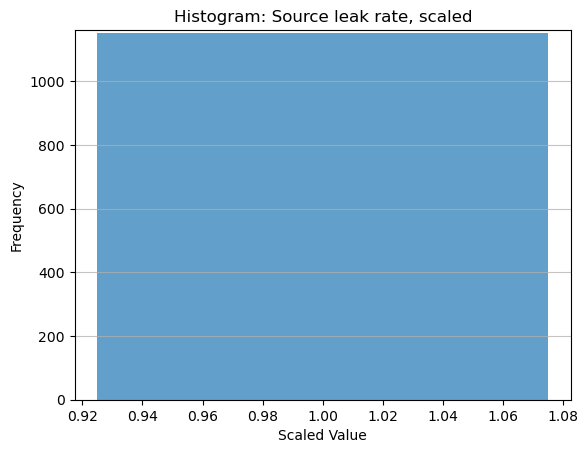

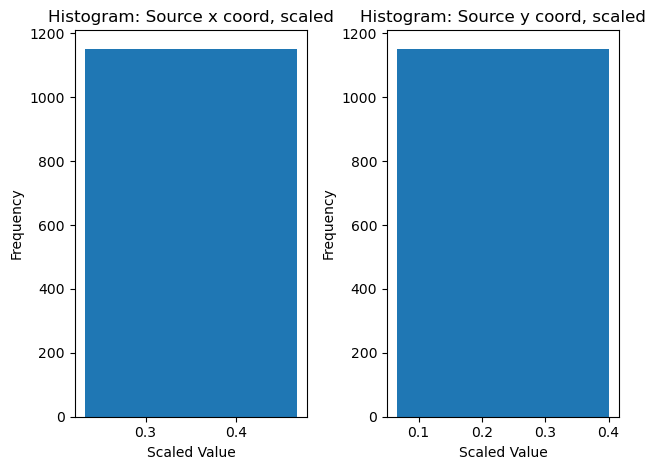

n_bins= 12


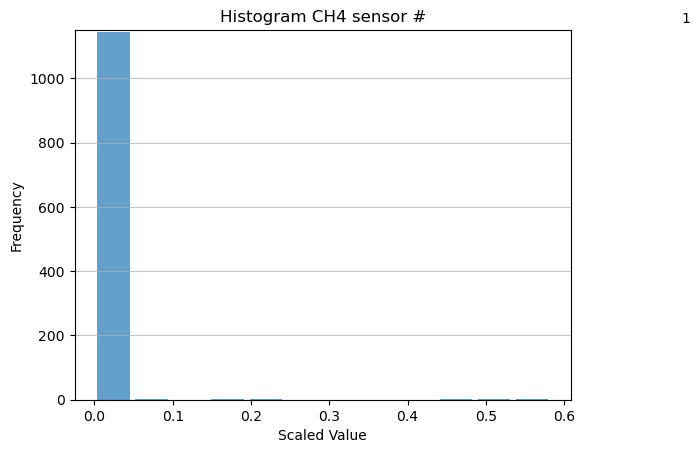

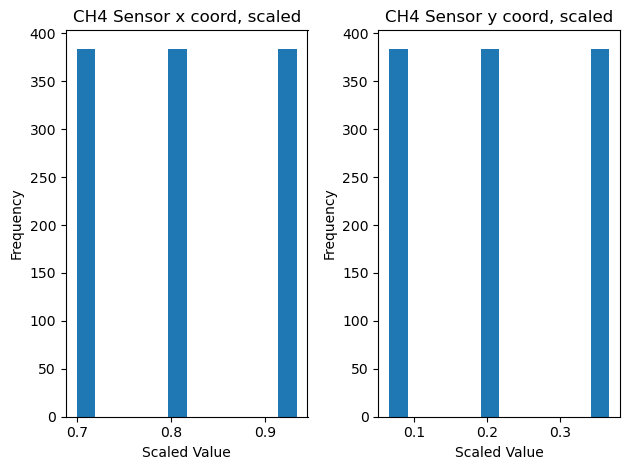

n_bins= 12


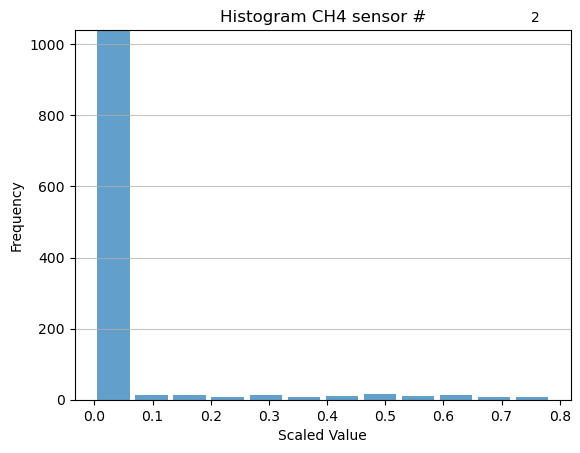

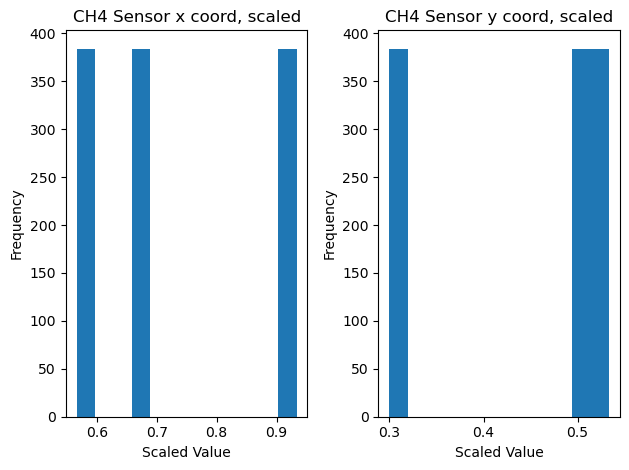

n_bins= 105


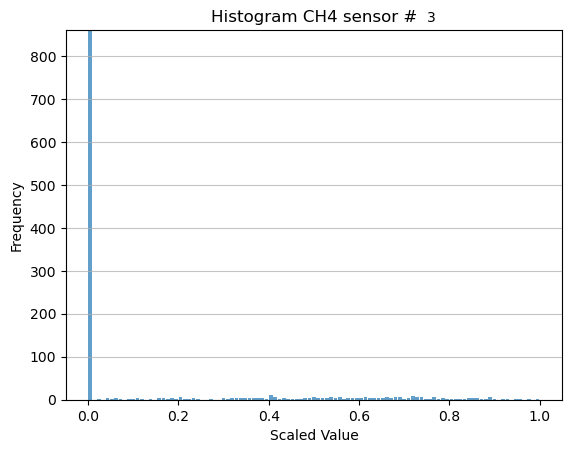

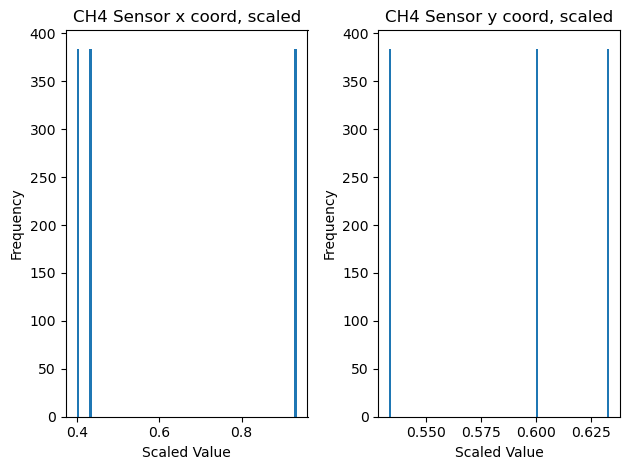

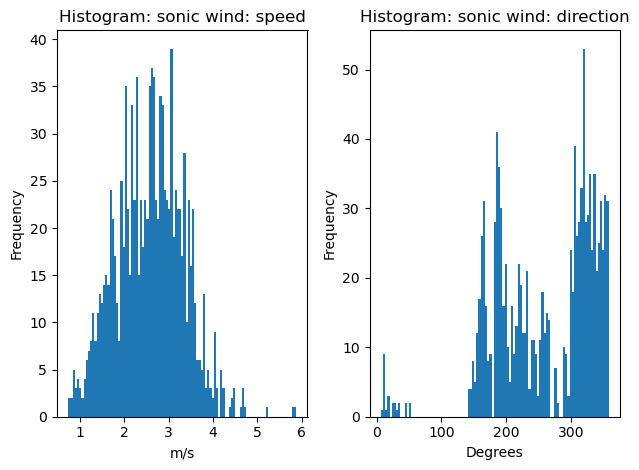

In [14]:
# HISTOGRAMS of INPUT DATA

# need to configure for SEALS project

# An "interface" to matplotlib.axes.Axes.hist() method

n, bins, patches = plt.hist(x=v_output[3], bins='auto', 
                            alpha=0.7, rwidth=0.15)
n_bins=len(bins)-1
print('n_bins=',n_bins)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')
plt.title('Histogram: Source leak rate, scaled')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

fig, axs = plt.subplots(1, 2,  tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
for ax in axs.flat:
    ax.set(xlabel='Scaled Value',ylabel='Frequency')
axs[0].hist(v_output[0], bins=n_bins)
axs[0].set_title('Histogram: Source x coord, scaled')
#plt.ylabel('Frequency')
axs[1].hist(v_output[1], bins=n_bins)
axs[1].set_title('Histogram: Source y coord, scaled')
plt.show()

for i in range(number_sensors):
    
    n, bins, patches = plt.hist(x=v_input[4*i+5], bins='auto', 
                            alpha=0.7, rwidth=0.85)
    n_bins=len(bins)-1
    print('n_bins=',n_bins)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Scaled Value')
    plt.ylabel('Frequency')
    plt.title('Histogram CH4 sensor #')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.text(0.75,maxfreq*1.025,i+1)
    plt.show()

    fig, axs = plt.subplots(1, 2,  tight_layout=True)
    for ax in axs.flat:
        ax.set(xlabel='Scaled Value',ylabel='Frequency')
    axs[0].hist(v_input[4*i+2], bins=n_bins)
    axs[0].set_title('CH4 Sensor x coord, scaled')
    #plt.ylabel('Frequency')
    axs[1].hist(v_input[4*i+3], bins=n_bins)
    axs[1].set_title('CH4 Sensor y coord, scaled')
    plt.show()
    
    
fig, axs = plt.subplots(1, 2,  tight_layout=True)
#for ax in axs.flat:
axs[0].set(xlabel='m/s',ylabel='Frequency')
axs[0].hist(v_input[0]*speed_max, bins=n_bins)
axs[0].set_title('Histogram: sonic wind: speed')
axs[1].set(xlabel='Degrees',ylabel='Frequency')
axs[1].hist(v_input[1]*360., bins=n_bins)
axs[1].set_title('Histogram: sonic wind: direction')
plt.show()


In [15]:
# FORM and FILL TRAINING and HOLDING arrays

# split data into training and testing and prediction
# want to split between files, not within group of records
# corresponding to a file

# holdouts = number of records to hold back, use for testing
# data = full set of info for all records, files
# train = data less holdouts
# model.fit will use some of 'train' info for validation

hold_files=int(prcnt*total_files)
train_files=total_files-hold_files

holdouts=hold_files*number_sensors*number_sensor_sets
splitting=train_files*number_sensors*number_sensor_sets

X_data=np.empty(shape=[total_inputs,n_ins])
y_data=np.empty(shape=[total_inputs,4])

X_train=np.empty(shape=[splitting,n_ins])
y_train=np.empty(shape=[splitting,4])

X_holdout=np.empty(shape=[holdouts,n_ins])
y_holdout=np.empty(shape=[holdouts,4])

y_pred_all=np.empty(shape=[splitting,4])

print('n_ins,total_files,total_inputs,splitting=',n_ins,total_files,total_inputs,splitting)

# fill in X_train, y_train from v_input and v_output

for i in range(total_inputs):
    for j in range(n_ins):
        X_data[i][j]=v_input[j][i]
    for k in range(4):
        y_data[i][k]=v_output[k][i]

# partition data into training plus holdout. holdout will be used as 
# final test of fit again 'unseen' data. train data will be further
# partitioned by model.fit through the validation_split parameter


for i in range(0,splitting):
    for j in range(n_ins):
        X_train[i][j]=X_data[i][j]
    for k in range(4):
        y_train[i][k]=y_data[i][k]

# holding out last prcnt fraction of files

for i in range(splitting,total_inputs):
    for j in range(n_ins):
        X_holdout[i-splitting][j]=X_data[i][j]
    for k in range(4):
        y_holdout[i-splitting][k]=y_data[i][k]
        

n_ins,total_files,total_inputs,splitting= 14 128 1152 1044


In [16]:
# DEFINE NN MODEL STRUCTURE

model=Sequential()

# define input layer shape

model.add(Input(shape=(n_ins,)))

# add input layer

model.add(Dense(activation = 'relu', units=64))

#Add 1st hidden layer; how big should it be?

model.add(Dense(64, activation='relu'))

#Add 2nd hidden layer; how big should it be?

model.add(Dense(64, activation='relu'))

#Add 3rd hidden layer; how big should it be?

model.add(Dense(32, activation='relu'))

# Adding the output layer

model.add(Dense(4,activation='sigmoid'))

# Compile the model using regular SGD;
# batch_size=1 so loss and metrics only done over a batch?
# would be best if over all batches. will add custom loss and metrics, but for now ...

model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['mse'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 11492 (44.89 KB)
Trainable params: 11492 (44.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


2024-01-14 16:24:26.989633: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
835/835 [==============================] - 2s 1ms/step - loss: 0.4043 - mse: 0.0374 - val_loss: 0.3066 - val_mse: 0.0072
Epoch 2/50
835/835 [==============================] - 1s 1ms/step - loss: 0.3039 - mse: 0.0068 - val_loss: 0.3043 - val_mse: 0.0071
Epoch 3/50
835/835 [==============================] - 1s 1ms/step - loss: 0.3026 - mse: 0.0066 - val_loss: 0.3025 - val_mse: 0.0065
Epoch 4/50
835/835 [==============================] - 1s 1ms/step - loss: 0.3013 - mse: 0.0062 - val_loss: 0.3012 - val_mse: 0.0061
Epoch 5/50
835/835 [==============================] - 1s 1ms/step - loss: 0.3002 - mse: 0.0058 - val_loss: 0.3002 - val_mse: 0.0057
Epoch 6/50
835/835 [==============================] - 1s 1ms/step - loss: 0.2986 - mse: 0.0052 - val_loss: 0.2993 - val_mse: 0.0054
Epoch 7/50
835/835 [==============================] - 1s 1ms/step - loss: 0.2973 - mse: 0.0048 - val_loss: 0.2970 - val_mse: 0.0046
Epoch 8/50
835/835 [==============================] - 1s 1ms/step - loss: 0.

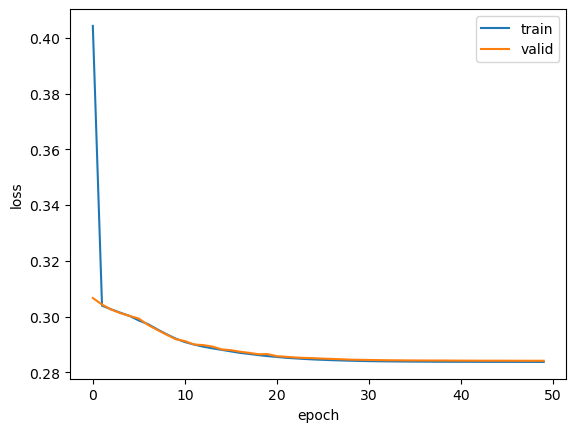

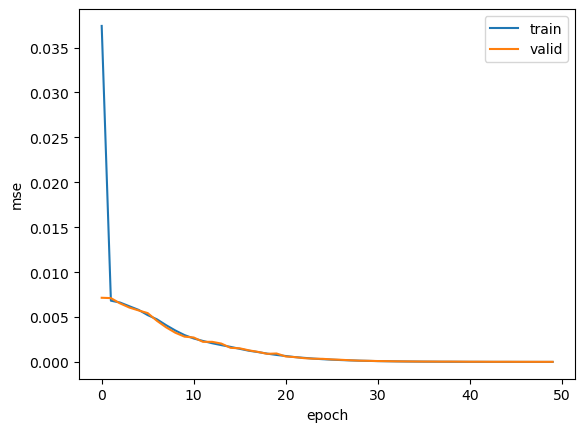

In [17]:
# TRAIN THE MODEL

# train data is split into two parts by the model - actual training plus validation

history=model.fit(X_train, y_train,validation_split=val_frac,batch_size=1,epochs=number_epochs,verbose=1)

# Capturing learning history per epoch

hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

# Plot loss function and mse vs epochs

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc ="upper right")
plt.show()

plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(hist['mse'])
plt.plot(hist['val_mse'])
plt.legend(("train" , "valid") , loc ="upper right")
plt.show()


1044/1044 [==============================] - 1s 797us/step


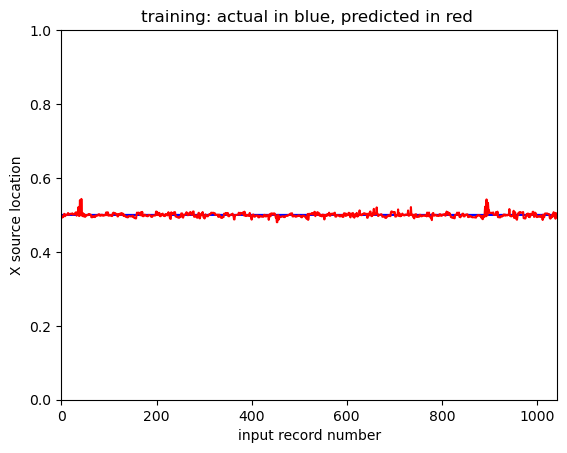

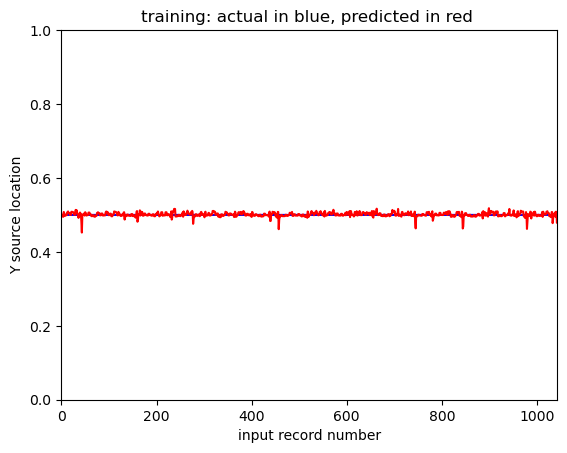

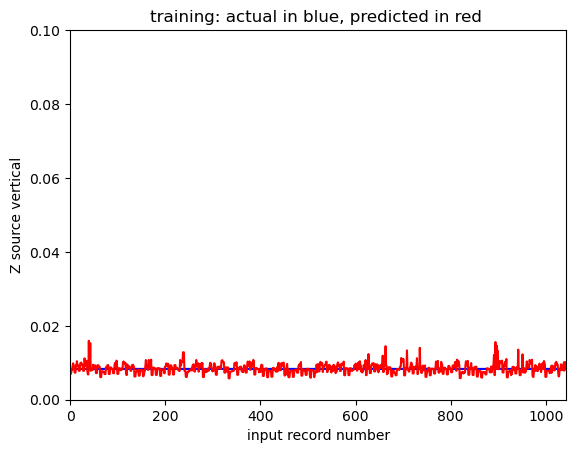

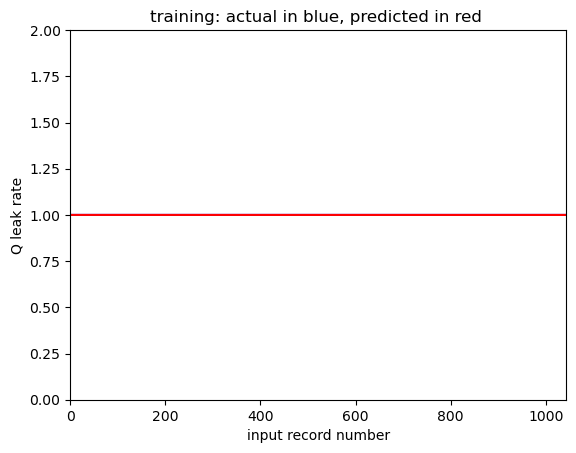

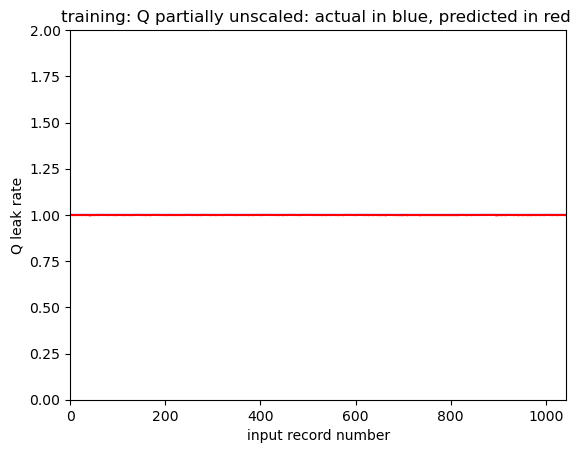

 rmse = 0.004063958610076971


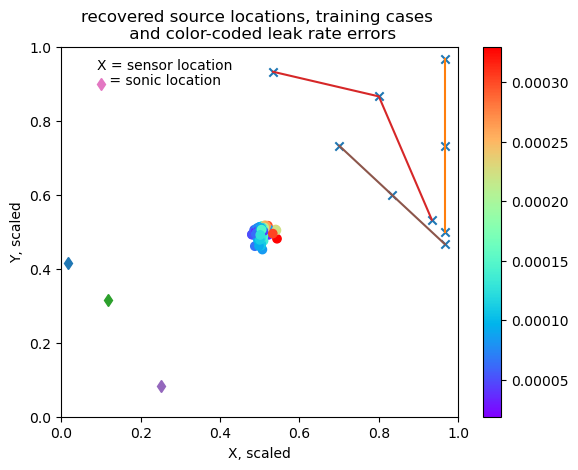

In [18]:
# TEST MODEL against TRAINING data

# apply model to training set to see how well/poorly true values are recovered

y_pred_all=model.predict(X_train,batch_size=1)

# print true vs predicted for x,y locations and leak rate

#print(' X.true,X.pred;Y.true,Y.pred;Z.true,Z.pred;Q.true,Q.pred')
#for i in range(splitting):
#    e=[y_train[i][0],y_pred_all[i][0],y_train[i][1],y_pred_all[i][1],y_train[i][2],y_pred_all[i][2],y_train[i][3],y_pred_all[i][3]]
#    print([round(x,2) for x in e])

# PLOTTING OF RESULTS

# plot individual features - all variables plotted are still scaled

sp=make_plots_recovered(splitting,number_sensor_sets,number_sensors,train_files,y_pred_all,
                     y_train,xyzscale,x_cellwidth,y_cellwidth,xref,yref,xvals,yvals,
                     sensor_x_i,sensor_y_i,sonic_x_i,sonic_y_i,0)



108/108 [==============================] - 0s 778us/step


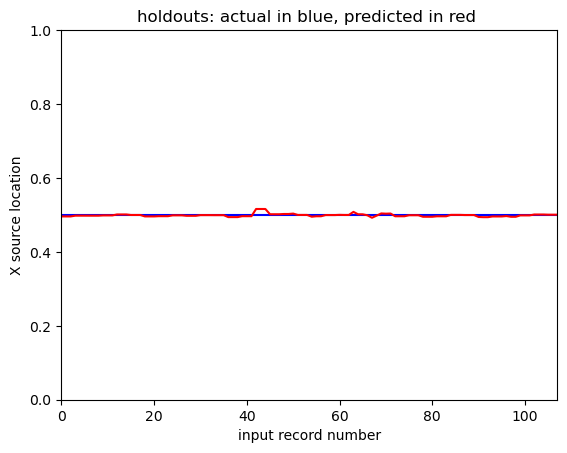

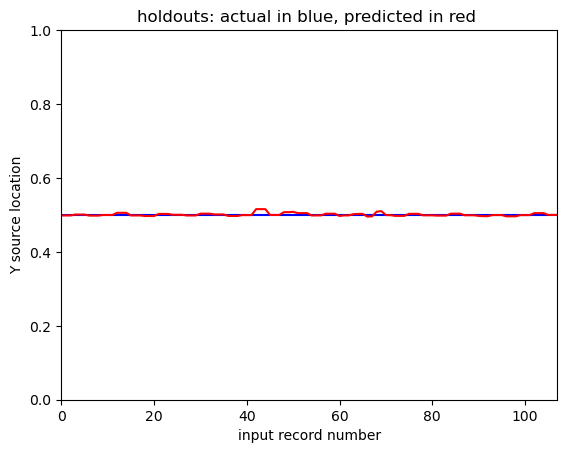

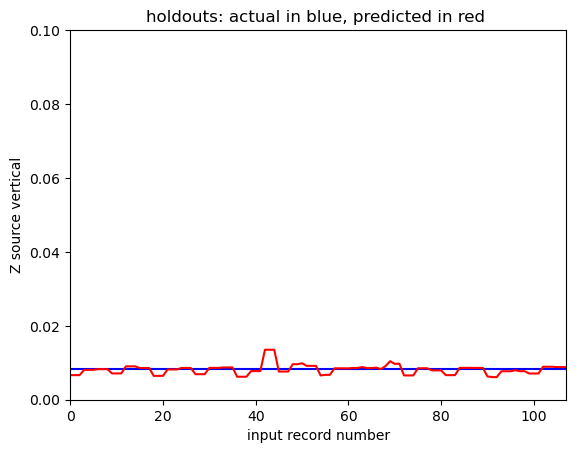

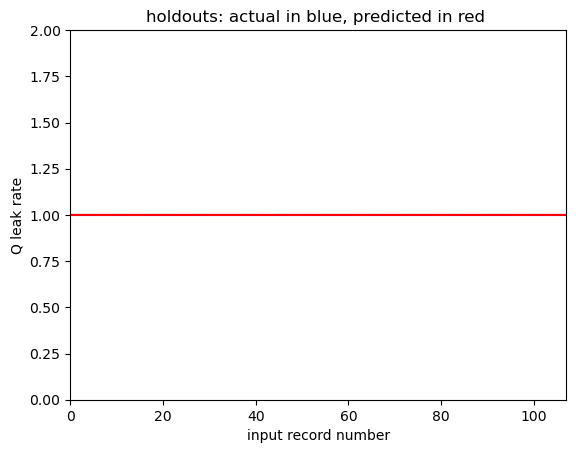

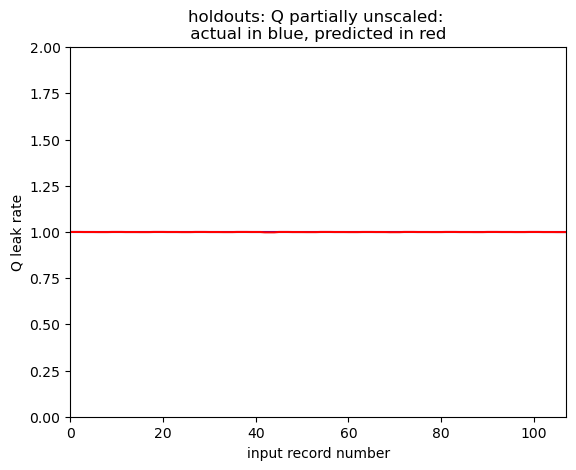

 rmse = 0.0029308633643416264


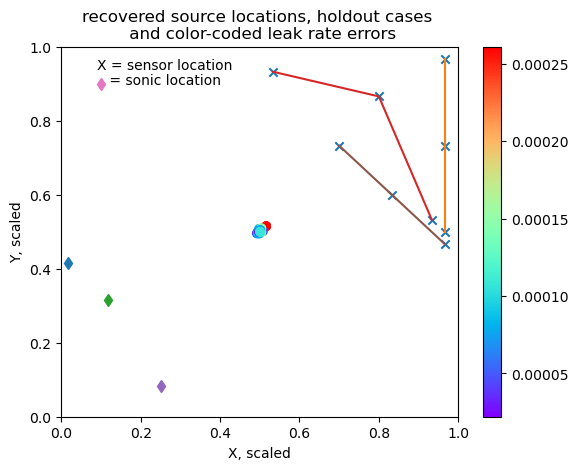

In [19]:
# APPLY MODEL TO HOLDOUT data

# apply model to holdout set to see how well/poorly model works for unseen data

y_pred_holdout=model.predict(X_holdout,batch_size=1)

# print true vs predicted for x,y,z coords of source and leak rate

#print(' for holdout data: \n X.true,X.pred;Y.true,Y.pred;Z.true,Z.pred;Q.true,Q.pred')
#for i in range(holdouts):
#    e=[y_holdout[i][0],y_pred_holdout[i][0],y_holdout[i][1],y_pred_holdout[i][1],y_holdout[i][2],y_pred_holdout[i][2],y_holdout[i][3],y_pred_holdout[i][3]]
#    print([round(x,2) for x in e])

# for holdouts, plot individual features - true vs predicted; all are still scaled, i.e., lie between 0 and 1.

sp=make_plots_recovered(holdouts,number_sensor_sets,number_sensors,hold_files,y_pred_holdout,
                     y_holdout,xyzscale,x_cellwidth,y_cellwidth,xref,yref,xvals,yvals,
                     sensor_x_i,sensor_y_i,sonic_x_i,sonic_y_i,1)
